# Introduction

This notebook is a demonstration on how to define and use a gated
Embedded-Model flow on the time series datasets with either continuity or
smoothness structures. The implementation for all the other experiments can be
found in the repo, which is currently under refactoring for official release.

In [1]:
!pip install tf-nightly tfp-nightly

In [2]:
import functools

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability.python.internal import prefer_static as ps

import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras
tfkl = tfk.layers
Root = tfd.JointDistributionCoroutine.Root

# Gated EMF
In the following code blocks there is an implementation fo the Gated EMF
bijector. For the non gated case, with most distributions it is possible to
create the EMF bijector by first defining a structure as a
`JointDistributionCoroutine` as we will see later, and then using

```bijector = tfe.bijectors.make_distribution_bijector(structure)```

The way to build the gated version is still in the development phase, and for
now works by first initializing a (global) dict containing the gating
parameters, one for each variable.

We then define a bijector class to turn Normal distributions into gated
bijectors (a more generic version is available in the file `gate_bijector
.py`). For gated transformations, we ha implemented the closed form solution
for the Normal distirbutions. There are more cases in which the closed form
transformation can be implemented, and those will be added in the official
release. For cases without closed form update, it is always possible to use
the numeric inverse, as implemented in the class `GateBijector` in
`gate_bijector.py` Finally, the `GatedAutoFromNormal` class allows us to turn
any `JointDistributionCoroutine` consisting of Normal distributions into a
gated bijector. Note that we have to manually define the bijective
transformations in the dict `gated_stdnormal_bijector_fns`.
Under the hood, the class `GatedAutoFromNormal` loops over the distributions
of the input `JointDistributionCoroutine`, and transforms each of those in
the corresponding bijective transformation.

We include a visual example of the sampling procedure for a generic GEMF-T in
 the figure below.

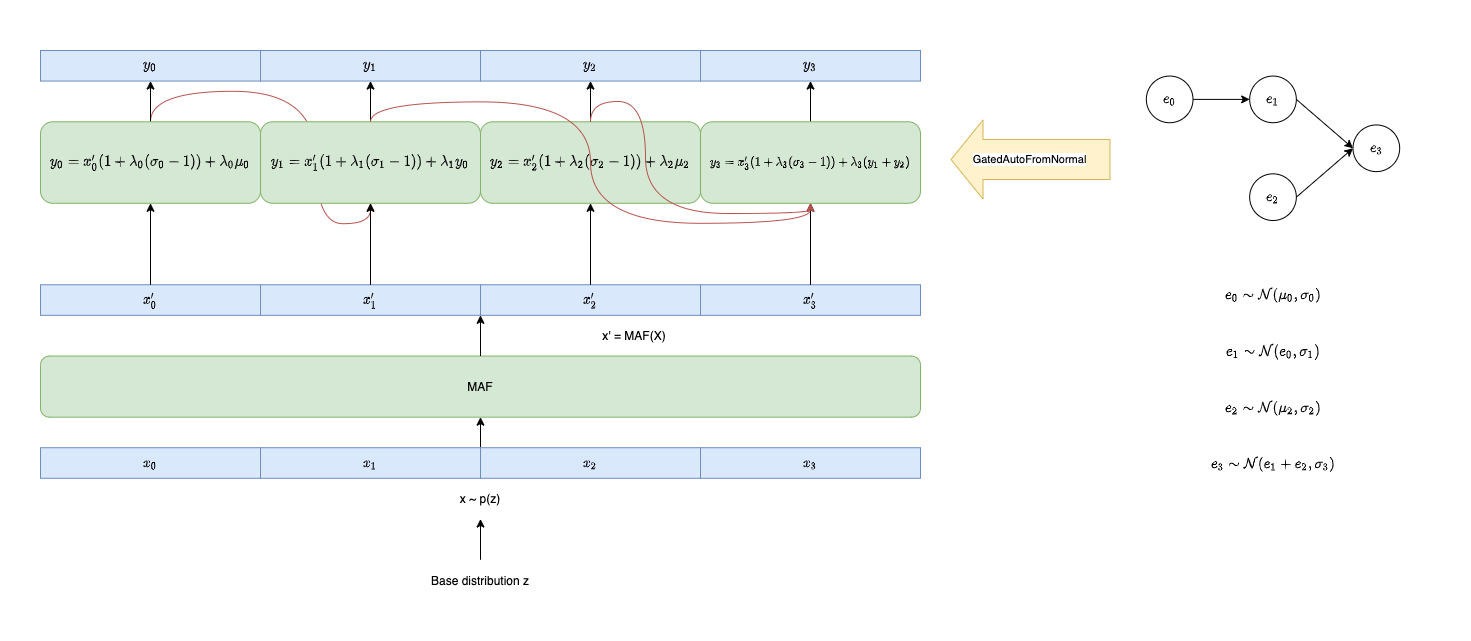

In [3]:
from IPython.display import Image
Image("EMF.png")

IWe use a global dict to keep track of the gatig parameters. When we create
the gated structured layer, we will initialize a new gate parameter
associated with the name of each random variable in the input structure.

In [4]:
# Global dict (DANGEROUS)
residual_fraction_vars = {}

def get_residual_fraction(dist):
  dist_name = dist.parameters['name']
  if dist_name not in residual_fraction_vars:
    bij = tfb.Chain([tfb.Sigmoid(), tfb.Scale(100)])
    residual_fraction_vars[dist_name] = tfp.util.TransformedVariable(0.999,
                                                                     bijector=bij,
                                                                     name=f'residual_fraction')   
  return residual_fraction_vars[dist_name]

The implementation of the gated bijector for Gaussian distributions.

In [5]:
class GateBijectorForNormal(tfb.Bijector):

  def __init__(self, loc, scale, residual_fraction, validate_args=False,
               name='gate_bijector_for_normal'):
    self.loc = loc
    self.scale = scale
    self.residual_fraction = residual_fraction
    super(GateBijectorForNormal, self).__init__(
      validate_args=validate_args,
      forward_min_event_ndims=0,
      name=name)

  def _forward(self, x):
    x = self.residual_fraction * (self.loc + self.scale * x) + \
        (1 - self.residual_fraction) * x
    return x

  def _inverse(self, y):
    y = (y - self.residual_fraction * self.loc) / (
          self.residual_fraction * self.scale + 1 - self.residual_fraction)
    return y

  def _forward_log_det_jacobian(self, x):
    fldj = tf.math.log(
      self.residual_fraction * (self.scale-1) + 1)
    return fldj


In [6]:
gated_stdnormal_bijector_fns = {
  tfd.Gamma: lambda d: tfd.ApproxGammaFromNormal(d.concentration,
                                                 d._rate_parameter()),
  # using specific bijector for normal, use next line for generic one
  tfd.Normal: lambda d: GateBijectorForNormal(d.loc, d.scale, get_residual_fraction(d)),
  # tfd.Normal: lambda d: GateBijector(tfb.Shift(d.loc)(tfb.Scale(d.scale)),
                                     # get_residual_fraction(d)),
  tfd.HalfNormal: lambda d: GateBijector(tfb.Softplus()(tfb.Scale(d.scale)),
                                         get_residual_fraction(d)),
  tfd.MultivariateNormalDiag: lambda d: GateBijector(
    tfb.Shift(d.loc)(tfb.Scale(d.scale)), get_residual_fraction(d)),
  tfd.MultivariateNormalTriL: lambda d: GateBijector(tfb.Shift(d.loc)(
    tfb.ScaleTriL(d.scale_tril)), get_residual_fraction(d)),
  tfd.TransformedDistribution: lambda d: d.bijector(
    _gated_bijector_from_stdnormal(d.distribution)),
  tfd.Uniform: lambda d: GateBijector(tfb.Shift(d.low)(
    tfb.Scale(d.high - d.low)(tfb.NormalCDF())), get_residual_fraction(d)),
  tfd.Sample: lambda d: _gated_bijector_from_stdnormal_sample(d.distribution),
  tfd.Independent: lambda d: _gated_bijector_from_stdnormal(d.distribution),
  tfd.MixtureSameFamily: lambda d: GateBijector(tfb.Chain([InverseMixtureOfGaussians(d), tfb.NormalCDF()]), get_residual_fraction(d))
}

def _gated_bijector_from_stdnormal(dist):
  fn = gated_stdnormal_bijector_fns[type(dist)]
  return fn(dist)

class GatedAutoFromNormal(tfd.joint_distribution._DefaultJointBijector):

  def __init__(self, dist):
    return super().__init__(dist, bijector_fn=_gated_bijector_from_stdnormal)

# Flows funcitons

In the following blocks we define a few functions to get Masked Autoregressive Flows (or their inverse, Inverse Autoregressive Flows) and Gated EMF.

In [7]:
def build_iaf_bijector(num_hidden_units,
                       ndims,
                       activation_fn,
                       dtype,
                       num_flow_layers=2, is_iaf=True):
  make_swap = lambda: tfb.Permute(ps.range(ndims - 1, -1, -1))

  def make_maf():
    net = tfb.AutoregressiveNetwork(
      2,
      hidden_units=[num_hidden_units, num_hidden_units],
      activation=activation_fn,
      dtype=dtype)

    maf = tfb.MaskedAutoregressiveFlow(
      bijector_fn=lambda x: tfb.Chain(
        [tfb.Shift(net(x)[Ellipsis, 0]),  # pylint: disable=g-long-lambda
         tfb.Scale(log_scale=net(x)[Ellipsis, 1])]))

    if is_iaf:
      maf = tfb.Invert(maf)
    # To track the variables
    maf._net = net  # pylint: disable=protected-access
    return maf

  iaf_bijector = [make_maf()]
  '''if not is_iaf:
    iaf_bijector.append(tfb.BatchNormalization())'''
  for _ in range(num_flow_layers - 1):
    iaf_bijector.extend([make_swap(), make_maf()])
    '''if not is_iaf:
      iaf_bijector.append(tfb.BatchNormalization())'''

  return iaf_bijector

The following block is a function to get some useful info about the
probabilistic program used as structure, such as the number of variables or
the total length. In addition, we create the so called
`prior_matching_bijector`, which is a simple bijector that maps a tensor into
 a StructTuple with the same form of the structure. For example, in the
 Lorenz System, the probabilistic program is a time series of length T=30, in
  which each variable is 3-dimensional. The base distribution and the
  normalizing flow will instead operate on a tensor of length 90, and the
  `prior_matching_bijector` will take care of reshaping everything so that it
   can be processed by the structured bijective transformation.

In [8]:
'''used to get some useful info about the input structure'''
def get_prior_matching_bijectors_and_event_dims(prior):
  event_shape = prior.event_shape_tensor()
  flat_event_shape = tf.nest.flatten(event_shape)
  flat_event_size = tf.nest.map_structure(tf.reduce_prod, flat_event_shape)
  try:
    event_space_bijector = prior.experimental_default_event_space_bijector()
  except:
    event_space_bijector = None

  split_bijector = tfb.Split(flat_event_size)
  unflatten_bijector = tfb.Restructure(
    tf.nest.pack_sequence_as(
      event_shape, range(len(flat_event_shape))))
  reshape_bijector = tfb.JointMap(
    tf.nest.map_structure(tfb.Reshape, flat_event_shape,
                          [x[tf.newaxis] for x in flat_event_size]))

  if event_space_bijector:

    prior_matching_bijectors = [event_space_bijector, unflatten_bijector,
                                reshape_bijector, split_bijector]

  else:
    prior_matching_bijectors = [unflatten_bijector,
                                reshape_bijector, split_bijector]

  dtype = tf.nest.flatten(prior.dtype)[0]

  return event_shape, flat_event_shape, flat_event_size, int(
    tf.reduce_sum(flat_event_size)), dtype, prior_matching_bijectors

Here is a simple function to create a normalizing flow (or surrogate
posterior in VI). We specify some parameters such as number of autoregressive
 layers and activation function, and then use `tfd.TransformedDistribution`
 to transform the base Gaussian distribution with the flow bjiector.

In [9]:
def get_maf(structure, flow_params={}):
  event_shape, flat_event_shape, flat_event_size, ndims, dtype, prior_matching_bijectors = get_prior_matching_bijectors_and_event_dims(
    structure)

  base_distribution = tfd.Sample(
    tfd.Normal(tf.zeros([], dtype=dtype), 1.), sample_shape=[ndims])
  if 'num_flow_layers' not in flow_params:
    flow_params['num_flow_layers'] = 2
  if 'num_hidden_units' not in flow_params:
    flow_params['num_hidden_units'] = 512
  if 'activation_fn' not in flow_params:
    flow_params['activation_fn'] = tf.math.tanh
  flow_params['dtype'] = dtype
  flow_params['ndims'] = ndims
  flow_params['is_iaf'] = False
  flow_bijector = build_iaf_bijector(**flow_params)

  nf_surrogate_posterior = tfd.TransformedDistribution(
    base_distribution,
    bijector=tfb.Chain(prior_matching_bijectors +
                       flow_bijector
                       ))

  return nf_surrogate_posterior

To add the gated structured layer, we can simply transform the normalizing
flow with an additional bijective transformation, always by using `tfd
.TransformedDistribution`.

In [10]:
def get_gated_emf_t(prior_structure, flow_params={}):
  residual_fraction_vars = {}
  flow_params['activation_fn'] = tf.nn.relu
  backbone_flow = get_maf(structure=prior_structure, flow_params=flow_params)
  bijector = GatedAutoFromNormal(prior_structure)
  return tfd.TransformedDistribution(
    distribution=backbone_flow,
    bijector=bijector
  )

# Training functions

In `build_model` we can initialize a new model. We can choose between MAF with two autoregressive layers (maf), MAF with three autoregressive layers (maf3) and gated EMF with structured bijector on top (gated_emf_t). We also specify the induced structures, continuity or smoothness. Finally, we define the toy datasets as generators, for Brownian Motion, Lorenz System and Ornstein-Uhlenbeck process.

In [11]:
@tf.function
def optimizer_step(net, inputs):
  with tf.GradientTape() as tape:
    loss = -net.log_prob(inputs)
  grads = tape.gradient(loss, net.trainable_variables)
  optimizer.apply_gradients(zip(grads, net.trainable_variables))
  return loss

In the following, if we use a simple flow model we will still need to specify
 a structure, so that the flow can use the data as we specify it. Note that
 this is arbitrary and not strictly needed (but needed for this
 implementation to work). However, tin case of non-structured models, the
 structure is only used to create the `prior_matching_bijector` mentioned
 earlier, to make sure that the output of the flow has the same StructTuple
 format as the data and the structured
 bijector is not added to the model. In case of structured bijector, we
 decide to have a trainable standard deviation parameter.

The structures to induce with EMF have to be defined as
`JointDistributionCoroutine` (we do that with the `@tfd.JointDistributionCoroutine`
decorator). These coroutines require the root variables (or the ones without
parents) to be wrapped in `Root`, so that they can keep track of the sample
batch shape, that will be propagated to the child variables.

In [12]:
def build_model(model_name, time_step_dim, series_len, structure):
    if model_name=='maf' or model_name == 'maf3':
      scales = tf.ones(time_step_dim)
    else:
      scales = tfp.util.TransformedVariable(tf.ones(time_step_dim), tfb.Softplus())
    initial_mean = tf.zeros(time_step_dim)

    if structure == 'continuity':
      @tfd.JointDistributionCoroutine
      def prior_structure():
        new = yield Root(tfd.Independent(tfd.Normal(loc=initial_mean,
                                    scale=tf.ones_like(initial_mean), name='prior0'),1))

        for t in range(1, series_len):
          new = yield tfd.Independent(tfd.Normal(loc=new,
                                 scale=scales,  name=f'prior{t}'), 1)

    elif structure == 'smoothness':
      @tfd.JointDistributionCoroutine
      def prior_structure():
        previous = yield Root(tfd.Independent(tfd.Normal(loc=initial_mean,
                                                    scale=tf.ones_like(initial_mean), name='prior0'), 1))
        current = yield Root(tfd.Independent(tfd.Normal(loc=initial_mean,
                                                    scale=tf.ones_like(initial_mean), name='prior1'), 1))
        for t in range(2, series_len):
          new = yield tfd.Independent(tfd.Normal(loc=2 * current - previous,
                                                 scale=scales, name=f'prior{t}'), 1)
          previous = current
          current = new

    prior_matching_bijector = tfb.Chain(
        get_prior_matching_bijectors_and_event_dims(prior_structure)[-1])

    if model_name == 'maf':
      flow = get_maf(prior_structure)
    elif model_name == 'maf3':
      flow_params={'num_flow_layers':3}
      flow = get_maf(prior_structure, flow_params)
    elif model_name == 'gated_emf_t':
      flow = get_gated_emf_t(prior_structure)

    # initialize model variables
    flow.log_prob(prior_structure.sample(1))

    return flow, prior_matching_bijector

Here we define the data generators, also as `JointDistributionCoroutine`s. 
the function `time_series_gen` uses such time series in a way that can be fed
 to the TensorFlow `tf.data.Dataset.from_generator`, to generate infinite 
 data samples.

In [13]:
@tfd.JointDistributionCoroutine
def lorenz_system():
  truth = []
  innovation_noise = .1
  step_size = 0.02
  loc = yield Root(tfd.Sample(tfd.Normal(0., 1., name='x_0'), sample_shape=3))
  for t in range(1, 30):
    x, y, z = tf.unstack(loc, axis=-1)
    truth.append(x)
    dx = 10 * (y - x)
    dy = x * (28 - z) - y
    dz = x * y - 8 / 3 * z
    delta = tf.stack([dx, dy, dz], axis=-1)
    loc = yield tfd.Independent(
      tfd.Normal(loc + step_size * delta,
                 tf.sqrt(step_size) * innovation_noise, name=f'x_{t}'),
      reinterpreted_batch_ndims=1)

@tfd.JointDistributionCoroutine
def brownian_motion():
  new = yield Root(tfd.Normal(loc=0, scale=.1))

  for t in range(1, 30):
    new = yield tfd.Normal(loc=new, scale=.1)

@tfd.JointDistributionCoroutine
def ornstein_uhlenbeck():
  a = 0.8
  new = yield Root(tfd.Normal(loc=0, scale=5.))

  for t in range(1, 30):
    new = yield tfd.Normal(loc=a*new, scale=.5)

def time_series_gen(batch_size, dataset_name):
  if dataset_name == 'lorenz':
    while True:
      yield tf.reshape(tf.transpose(tf.convert_to_tensor(lorenz_system.sample(batch_size)),[1,0,2]), [batch_size, -1])
  elif dataset_name == 'brownian':
    while True:
      yield tf.math.exp(tf.reshape(tf.transpose(tf.convert_to_tensor(brownian_motion.sample(batch_size)),[1,0]), [batch_size, -1]))
  elif dataset_name == 'ornstein':
    while True:
      yield tf.reshape(tf.transpose(tf.convert_to_tensor(ornstein_uhlenbeck.sample(batch_size)),[1,0]), [batch_size, -1])

# Model Training

The cell below can be modified to change the training settings. You can 
choose number of iterations, learning rate, dataset, model and induced 
structure. If you use a model without structure, please leave 
`structure='continuity'`.

In [14]:
### Modify here ####
num_iterations = int(50) # kept low just for demo
dataset_name = 'lorenz' # brownian, ornstein, lorenz
model_name = 'gated_emf_t' # maf, maf3, gated_emf_t
structure = 'continuity' # 'continuity', 'smoothness'
lr = 1e-4
###################

if dataset_name == 'lorenz':
  time_step_dim = 3
  series_len = 30

elif dataset_name == 'brownian' or dataset_name == 'ornstein':
  time_step_dim = 1
  series_len = 30

In [15]:
flow, prior_matching_bijector = build_model(model_name, time_step_dim, series_len, structure)
dataset = tf.data.Dataset.from_generator(functools.partial(time_series_gen, batch_size=int(100), dataset_name=dataset_name),
                                             output_types=tf.float32).map(prior_matching_bijector).prefetch(tf.data.AUTOTUNE)

2021-11-15 23:16:38.230126: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=lr, decay_steps=5e5)
optimizer = tf.optimizers.Adam(learning_rate=lr_decayed_fn)

In [17]:
train_loss_results = []

epoch_loss_avg = tf.keras.metrics.Mean()
it = 0
for x in dataset:

  # Optimize the model
  loss_value = optimizer_step(flow, x)
  epoch_loss_avg.update_state(loss_value)

  if it == 0:
    best_loss = epoch_loss_avg.result()
    epoch_loss_avg = tf.keras.metrics.Mean()
  ## change here to get an average loss more or less often
  elif it % 1 == 0:
    train_loss_results.append(epoch_loss_avg.result())
    #print(train_loss_results[-1])
    epoch_loss_avg = tf.keras.metrics.Mean()

  if it >= num_iterations:
    break
  it += 1

2021-11-15 23:16:42.825418: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


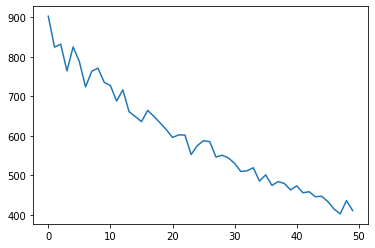

In [18]:
plt.plot(train_loss_results)

In [19]:
eval_dataset = tf.data.Dataset.from_generator(functools.partial(time_series_gen, batch_size=int(1e4), dataset_name=dataset_name),
                                             output_types=tf.float32).map(prior_matching_bijector)

eval_log_prob = -tf.reduce_mean(flow.log_prob(next(iter(eval_dataset))))
print(eval_log_prob)

tf.Tensor(406.459, shape=(), dtype=float32)
